Here, some exploratory techniques will be applied to the region-level time series to identify the network factors.

### Methods
- conditioning on networks using formula
- MEAN: averaging region time series with a network
- PCA: the first component of the PCA on the region time series
- UMAP: the first component of the UMAP on the region time series
- DOWHY: causal inference on the region time series

In [1]:
# uncomment if formulae or dowhy are not installed.
# Alternatively, you can install them with pip install formulae dowhy

# %conda install formulae dowhy

In [3]:
from python.acnets.pipeline import Parcellation
import pandas as pd
import numpy as np

from formulae import design_matrices

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from umap import UMAP


In [4]:
atlas = 'dosenbach2010'
p = Parcellation(atlas)
DATA = p.fit_transform(None)

X = pd.DataFrame(DATA[0].T, index=p.labels_.index)
X.columns = [f't{c}' for c in X.columns]
X = X.join(p.labels_).drop(columns=list('xyz'))

In [5]:

timestep_term = '+'.join(X.columns).replace('+network', '|network')

d1 = design_matrices(f'({timestep_term})', X).group
d2 = design_matrices(f'({timestep_term})', X).group

# sns.heatmap(d1['t1|network'])
# plt.show()
# sns.heatmap(d1['t2|network'])

# X.groupby('network')['t1'].mean(), d1.mean(axis=0), d2.mean(axis=0)
d1['t1|network'].mean(), d1['t20|network'].mean(), d1['t1|network'].shape

(88.56784624936209, 88.52282564988197, (160, 6))

In [13]:
ts_pca.shape

(125, 21)

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


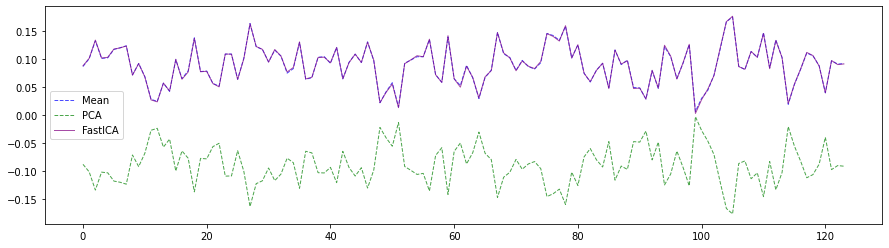

In [22]:
X_one_network = X.query('network == "sensorimotor"').drop(columns='network').T

# alternatives to PCA
from sklearn.decomposition import KernelPCA, FactorAnalysis, SparsePCA, IncrementalPCA
from sklearn.decomposition import FastICA

ts_mean = X_one_network.mean(axis=1).values
ts_pca = PCA(n_components='mle', whiten=True).fit_transform(X_one_network)
ts_ica = FastICA(n_components=1).fit_transform(X_one_network)
ts_umap = UMAP(n_components=1).fit_transform(X_one_network)

ts_mean = (ts_mean - ts_mean.mean()) / ts_mean.std()
ts_pca = (ts_pca - ts_pca.mean()) / ts_pca.std()
ts_ica = (ts_ica - ts_ica.mean()) / ts_ica.std()
ts_umap = (ts_umap - ts_umap.mean()) / ts_umap.std()

# FIXME for some reasons, ICA/PCA produces inverted values. For visualization we negate them

plt.figure(figsize=(15,4))
sns.lineplot(y=ts_mean[:124],x=range(0,124), color='blue', label='Mean', alpha=.7, ls='--', lw=1)
sns.lineplot(y=ts_pca[:124,0],x=range(0,124),color='green', label='PCA', alpha=.7, ls='--', lw=1)
# sns.lineplot(y=ts_umap[:124,0],x=range(0,124),color='red', label='UMAP', alpha=.7, lw=1)
sns.lineplot(y=ts_ica[:124,0],x=range(0,124),color='purple', label='FastICA', alpha=.7, lw=1)

plt.legend()

In [135]:
pca = PCA(n_components='mle', whiten=True)
pca.fit_transform(X_one_network)
pca.explained_variance_ratio_

array([0.53967733, 0.12413248, 0.06951533, 0.04494365, 0.04260812,
       0.03093722, 0.02419276, 0.01554315, 0.01431737, 0.01229751,
       0.01205353, 0.00893703, 0.00738337, 0.00709851, 0.00649412,
       0.00535659, 0.0049846 , 0.00430482, 0.0034524 ])

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
Causal estimate: -6.806707004689201
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treat

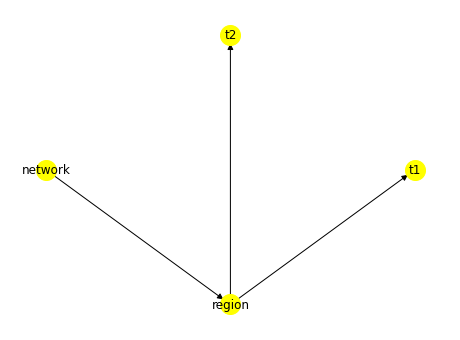

In [316]:
# I. Create a causal model from the data and given graph.

from dowhy import CausalModel
import dowhy.api

X_dowhy = X.copy()
X_dowhy['network'] = X_dowhy['network'].astype('category').cat.codes
X_dowhy = X_dowhy[['t1','t2','network']].reset_index()
# X_dowhy[['t1','network']].causal.do(
#     x='network',
#     outcome='t1',
#     variable_types={'t1':'c', 'network': 'd'})

model = CausalModel(
    data=X_dowhy,
    treatment='network',
    outcome=['t1','t2'],
    graph='digraph { network -> region;region-> t1; region -> t2}')
model.view_model()

# # Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
# print(identified_estimand)

# # III. Estimate the target estimand using a statistical method.
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.linear_regression')

print('Causal estimate:', estimate.value)

# # IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name='random_common_cause')

print('refuting results:', refute_results.refutation_result)

In [ ]:
## Dirty Network masker
from nilearn import maskers, datasets, plotting, image, surface
import numpy as np
from python.acnets.parcellations import gordon

atlas = gordon.fetch_atlas()

maps_data = image.get_data(atlas['maps'])
atlas.labels['network'] = atlas.labels['network'].astype('category')
region2network_mapping = atlas.labels['network'].cat.codes + 1
region2network_mapping = region2network_mapping.to_dict()
# atlas.labels['network'].cat.categories
none_regions = atlas.labels.query('network == "None"').index
none_idx = atlas.labels['network'].cat.categories.to_list().index('None') + 1
map_r2n = lambda x: region2network_mapping[int(x)] if x not in [0,none_idx] else 0
maps_data = np.vectorize(map_r2n)(maps_data)

new_maps = image.new_img_like(atlas['maps'], maps_data)
new_maps.to_filename('a.nii.gz')

fsaverage = datasets.fetch_surf_fsaverage()

# plotting.plot_epi(new_maps, colorbar=True)
# plotting.plot_img(new_maps, colorbar=True)
# plotting.plot_roi(new_maps, title='Gordon Atlas', colorbar=True)

# aa = surface.vol_to_surf(new_maps, fsaverage.pial_left)

# plotting.view(fsaverage['pial_left'], roi_map=aa,
#                        hemi='left', view='lateral',
#                        bg_map=fsaverage['sulc_left'], bg_on_data=True,
#                        darkness=.5)

plotting.view_img(new_maps, symmetric_cmap=False, black_bg=False).open_in_browser()

# plotting.view_surf(fsaverage.white_right, aa).open_in_browser()
# plotting.plot_glass_brain(new_maps, colorbar=True, annotate=True)
# plotting.plot_epi(net_maps,cut_coords=(0,-10,-55), colorbar=True)

In [ ]:
chart = pg.Line(_self_close=False, _max=10)

for (network,subject),data  in network_timeseries['timeseries_mean'].iteritems():
  if network in ['Visual','FrontoParietal']:
    chart.add(network, data)

from IPython.display import SVG
SVG(chart.render())

# Cross-correlation (DEBUG)

import sklearn
sklearn.set_config(display='diagram')
grid

# import statsmodels.api as sm
# sm.tsa.stattools.ccf([1,2,3,4,5,6,7,8,0], [0,0,1,2,3,4,5,6,7], adjusted=True)

In [ ]:

def plot_connectivity_heatmap(all_conns, title, plot_diff, ax):

    if plot_diff:
        avgp = conn.subject.str.contains("AVGP").values
        data = conn[avgp].mean(dim='subject').values - conn[~avgp].mean(dim='subject').values
    else:
        data_std = all_conns.values.std(axis=0)
        data_std  = np.where(np.isfinite(data_std), data_std, 0)
        data_std  = np.where(np.isnan(data_std), 0, data_std)
        data = all_conns.mean(dim='subject').values / data_std
        np.fill_diagonal(data, 0)

    sns.heatmap(
        data,
        yticklabels=conn.coords['node'].values,
        xticklabels=conn.coords['node'].values,
        annot=True, fmt='.2f',
        ax=ax,
        square=True,
        # vmax=data.max(),
        # figsize=(7, 7),
        # dendrogram_ratio=0.001,
        # cbar_pos=(1., 0.3, 0.03, 0.6)
        cmap='Blues',
        annot_kws={"size":'medium'}
        # cbar=False,
    )
    ax.set_title(f'$\\bf{{{title}}}$', fontsize='xx-large')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize='xx-large')
    ax.set_yticklabels(ax.get_xticklabels(), rotation=0, ha='right', rotation_mode='anchor', fontsize='xx-large')


conn = extract_connectivity(atlas='seitzman2018', connectivity='chatterjee', aggregate_networks=True)
avgp = conn.subject.str.contains("AVGP").values

fig, axes = plt.subplots(1, 2, figsize=(17, 6), sharey=True)
plot_connectivity_heatmap(conn[avgp], title='AVGP', plot_diff=False, ax=axes[0])
plot_connectivity_heatmap(conn[~avgp], title='NVGP', plot_diff=False, ax=axes[1])
# plot_connectivity_heatmap(conn[~avgp], title='AVGP - NVGP', plot_diff=True, ax=axes)

plt.suptitle('SNR (mean$\div$std) for {atlas} chatterjee (network)', fontsize=24, y=1.01)
plt.show()

In [ ]:
%scipt skipping...

DEMO_ATLAS = 'seitzman2018'
DEMO_CONNECTIVITY_KIND = 'tangent'

conn_dataset = ConnectivityPipeline(atlas=DEMO_ATLAS, kind=DEMO_CONNECTIVITY_KIND).transform(None)
subjects = conn_dataset.coords['subject'].values
subject_groups = np.array([s[:4] for s in subjects])
conn_vec = ConnectivityVectorizer(only_diagonal=True).fit_transform(conn_dataset)

plotting_data = pd.DataFrame(conn_vec, columns=conn_dataset.coords['node'].values)
plotting_data['group'] = subject_groups

plotting_data = plotting_data.melt(
    id_vars=['group'],
    var_name='network',
    value_name='connectivity')

n_networks = plotting_data['network'].nunique()

_, ax = plt.subplots(figsize=(n_networks * .8, 3))
sns.lineplot(data=plotting_data, x='network', y='connectivity', hue='group', sort=False)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.suptitle(f'$\\bf{{{DEMO_ATLAS.replace("_","-")}}}$ '
             f'(diagonal {DEMO_CONNECTIVITY_KIND})', y=.96)
plt.xlabel('')
plt.show()